## Importing Necessary Libraries and Functions

The first thing we need to do is import the necessary functions and libraries that we will be working with throughout the topic. We should also go ahead and upload all the of the necessary data sets here instead of loading them as we go. We will be using energy production data from PJM Interconnection. They are a regional transmission organization that coordinates the movement of wholesale electricity in parts of the United States. Specifically, we will be focused on a region of Pennsylvania. We will also be using temperature data collected from the National Oceanic and Atmospheric Assocation (NOAA).

In [ ]:
!conda update -n base -c defaults conda

!conda install pandas -y
!conda install numpy -y
!conda install matplotlib -y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This milestone builds off the previous one so we should complete the following steps to the first milestone again to have our data prepped and ready to go!

## Preparing the Energy and Temperature Data

First we need to load our weather and energy data sets for cleaning. Let's use the pandas library and the ```read.csv``` function to do this.

In [2]:
# Loading the Needed Data Sets 
weather = pd.read_csv('.../hr_temp_20170201-20200131_subset.csv')
energy = pd.read_csv('.../hrl_load_metered - 20170201-20200131.csv')


It is always good practice to take a look at the first few observations of the data set to make sure that everything looks like how we expected it to when we read in our CSV file. Let's use the ```head``` function for this.

In [3]:
weather.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01T00:53:00,FM-15,7,37.0
1,72520514762,2017-02-01T01:53:00,FM-15,7,37.0
2,72520514762,2017-02-01T02:53:00,FM-15,7,36.0
3,72520514762,2017-02-01T03:53:00,FM-15,7,36.0
4,72520514762,2017-02-01T04:53:00,FM-15,7,36.0


Perfect! We have temperature as well as time. There are some other pieces of information like the station number, source of the reading and reading type, but we don't need those.

Let's take a look at the first few observations of the energy data as well!

In [4]:
energy.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True


Great! Again, we have the important information of time as well as megawatt (MW) readings per hour. Again, there are some other varibales that we won't end up using in this data set as well.

Let's get rid of the variables we don't need and combine the variables that we do need into one pandas data frame. Dictionaries are an easy way of doing this. Here, we are pulling the MW column from the energy data set as well as the temperature and date columns from the weather data set. These data sets already line up on time which makes this much easier.

In [5]:
d = {'MW': energy['mw'], 'Temp': weather['HourlyDryBulbTemperature'], 'Date': weather['DATE']}

Now let's create our pandas data frame.

In [6]:
df = pd.DataFrame(d)

One of the problems when loading a data set you want to run time series analysis on is the type of object Python sees for the "date" variable. Let's look at the pandas data frame data types for each of our variables.

In [7]:
print(df.dtypes)

MW      float64
Temp    float64
Date     object
dtype: object


Here we can see that the Date variable is a general object and not a "date" according to Python. We can change that with the pandas function ```to_datetime``` as we have below.

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

MW             float64
Temp           float64
Date    datetime64[ns]
dtype: object


Good! Now that we have a ```datetime64``` object in our data set we can easily create other forms of date variables. The hour of day, day of week, month of year, and possibly even the year itself might all impact the energy usage. Let's extract these variables from our date object so that we can use them in our analysis. Pandas has some wonderful functionality to do this with the ```hour```, ```day```, ```dayofweek```, ```month```, and ```year``` functions. Then let's inspect the first few observations to make sure things look correct.

In [9]:
df['hour'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).hour
df['day'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).day
df['weekday'] = df['Date'].dt.dayofweek
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).month
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['Date'])).year

df.head()

,MW,Temp,Date,hour,day,weekday,month,year
0,1419.881,37.0,2017-02-01 00:53:00,0,1,2,2,2017
1,1379.505,37.0,2017-02-01 01:53:00,1,1,2,2,2017
2,1366.106,36.0,2017-02-01 02:53:00,2,1,2,2,2017
3,1364.453,36.0,2017-02-01 03:53:00,3,1,2,2,2017
4,1391.265,36.0,2017-02-01 04:53:00,4,1,2,2,2017


Everything looks good in the first few observations above. If you still aren't convinced you could pull different pieces of the data frame to make sure that other observations are structured correctly.

Now we should set this Python date object as the index of our data set. This will make it easier for plotting as well as forecasting later. We can use the ```set_index``` function for this.

In [10]:
df = df.set_index('Date')

Good! Now that we have our data structured as we would like, we can start the cleaning of the data. First, let's check if there are any missing values in the temperature column. The ```is.null``` function will help us here.

In [11]:
sum(df['Temp'].isnull())

37

Looks like there are 37 missing values in our temperature data. We shoudl impute those. However, we don't just want to put the average temperature in these spots as the overall average across three years probably isn't a good guess for any one hour. The temperature of the hours on either side of the missing observation would be more helpful. Let's do a linear interpolation across missing values to help with this. This will essentially draw a straight line between the two known points to fill in the missing values. We can use the ```interpolate(method='linear')``` function for this.

In [12]:
df['Temp'] = df['Temp'].interpolate(method='linear')

Now let's see if we have any more missing temperature values.

In [13]:
sum(df['Temp'].isnull())

0

No more! Time to check if the energy data has any missing values.

In [14]:
sum(df['MW'].isnull())

0

No missing values there either! Perfect.

Now it is time to split the data into two pieces - training and testing. The training data set is the data set we will be building our model on, while the testing data set is what we will be reporting results on since the model wouldn't have seen it ahead of time. Using the date index we can easily do this in our data frame.

In [15]:
#Training and Validation Split #
train = pd.DataFrame(df['2017-01-01':'2019-12-31'])
test = pd.DataFrame(df['2020-01-01':'2020-01-31'])

Now let's look at the first few observations for our training data set.

In [16]:
train.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,1,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,1,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,1,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,1,2,2,2017


Everything looks good there!

Now let's do the same for our testing data set.

In [17]:
test.head()

,MW,Temp,hour,day,weekday,month,year
Date,,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,1,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,1,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,1,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,1,2,1,2020


Excellent! We now have our data cleaned and split. By combining and cleaning the data sets, we will make the exploration of these data sets as well as the modeling of these data sets much easier for the upcoming sections!

## Exploring / Visualizing Energy and Temperature Data 

Now that we have recreated the pieces of milestone 1 that clean and split our data we can start the data exploration phase of milestone 2.

Since our energy data is the main focus of this project, let's plot it first. Again, everything we are doing here focuses on the training data set. The test data set is only used after the modeling phase of the project is complete. Let's use matplotlib's ```plot``` function on our MW variable in the training data. I have added some labels to make it easier to visualize.

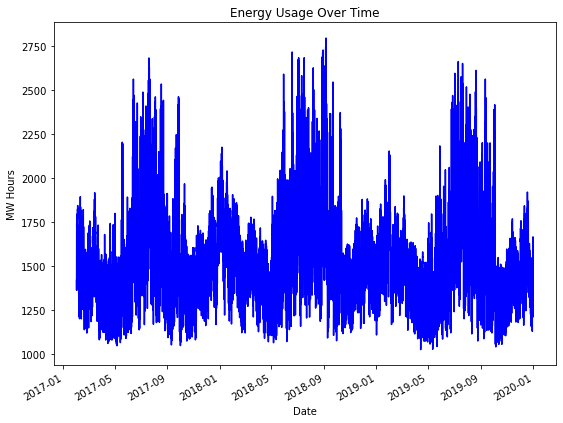

In [18]:
ax1 = train['MW'].plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('MW Hours')
ax1.set_xlabel('Date')
ax1.set_title('Energy Usage Over Time')

plt.show()

Looks like we have some interesting patterns in the plot above. It appears as though energy usage does cyclically move throught the year. In the spring and fall seasons, we see a drop in energy usage. This is probably due to mild temperatures making it easier (or even not necessary) to heat and cool buildings. In the winter months we see some spikes as buildings need to be heated. However, with a variety of different heating methods, electricity might not be needed in some buildings for heating. The biggest spikes appear in the summer months. This isn't too surprising. The most common way to cool a building is by using electricity to do so through AC systems.

It can be a little bit hard from this very wide view of the plot to really see if there are more granular patterns going on. Let's zoom in on a week of data in December to 2017 to see what an individual week of energy usage looks like.

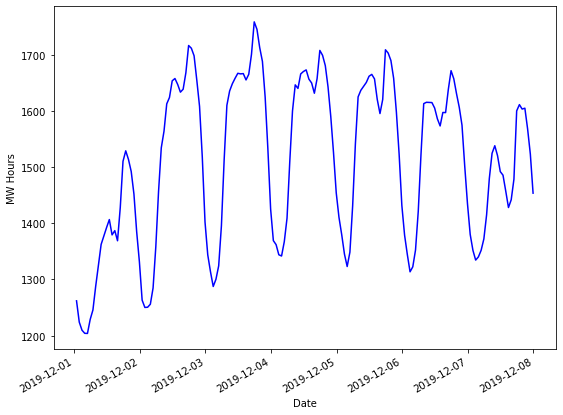

In [19]:
train_mw = train['MW']

ax1 = train_mw['2019-12-01':'2019-12-07'].plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('MW Hours')
ax1.set_xlabel('Date')

plt.show()

Now we can really see some interesting patterns! In the above plot we have Sunday through Saturday. We can easily see that Sunday and Saturday have drastically lower energy usage than the rest of the week. This isn't too surprising as most major businesses are closed on the weekends and don't need to manage the temperature of their buildings or have lights on.

Temperature outside is a big driving force behind energy usage. Let's examine the same time frames for temperature that we did for energy!

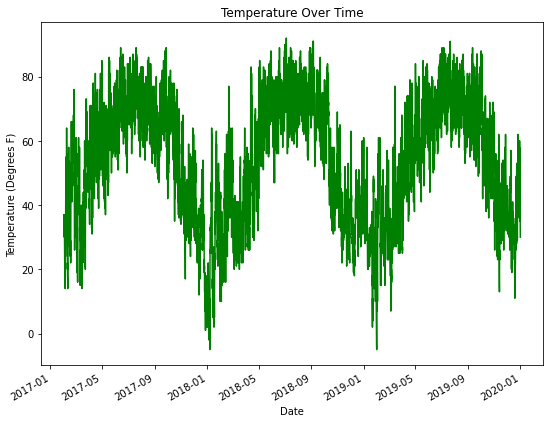

In [20]:
ax2 = train['Temp'].plot(color = 'green', figsize=(9,7))

ax2.set_ylabel('Temperature (Degrees F)')
ax2.set_xlabel('Date')
ax2.set_title('Temperature Over Time')

plt.show()

We see that temperature has a different overall pattern than energy usage. Not surprisingly, winter months are the coldest while summer months are the hottest. From this plot it might not seem that we can use temperature to predict energy as the patterns look different. Let's iverlay them onto the same plot to see if that helps show any possible relationship.

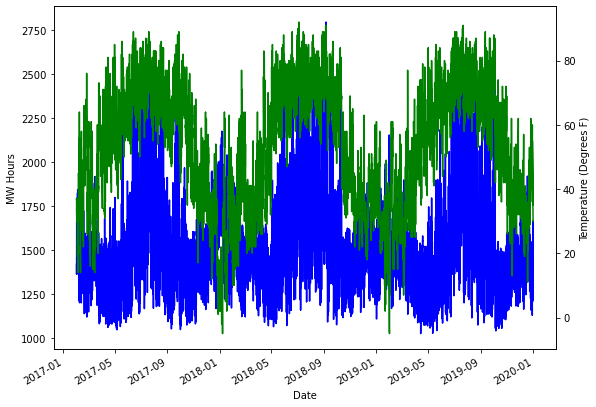

In [21]:
ax1 = train['MW'].plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('MW Hours')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()

ax2 = train['Temp'].plot(color = 'green', figsize=(9,7))

ax2.set_ylabel('Temperature (Degrees F)')

plt.show()

Now we can start to see the relationship we were expecting from earlier! When temperature is **either** really cold or really hot (winter or summer), more energy gets used. When temperature is more mild outside (spring or fall), less energy gets used. So it looks like temperature and energy **do** have a relationship. Just potentially a complicated one. Let's remember this for our modeling!

Now let's zoom into one week of temperature and energy. However, let's examine both a week in the winter and a week in the summer.

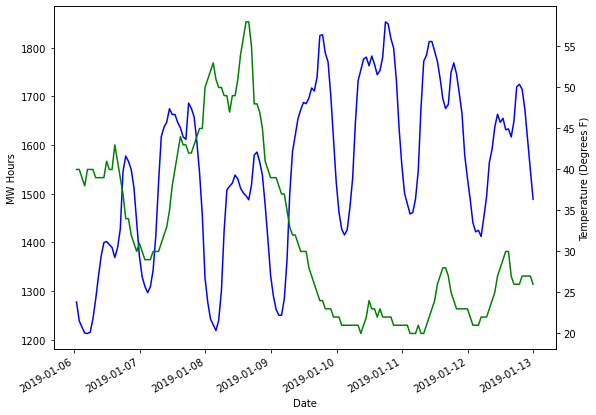

In [22]:
train_mw = train['MW']
train_t = train['Temp']

ax1 = train_mw['2019-01-06':'2019-01-12'].plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('MW Hours')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()

ax2 = train_t['2019-01-06':'2019-01-12'].plot(color = 'green', figsize=(9,7))

ax2.set_ylabel('Temperature (Degrees F)')

plt.show()

The relationship between temperature and energy seems like we would expect from this plot of a week in Janurary. When temperature spiked for a day or two, we see lower energy usage since it didn't take as much to heat the buildings. However, when temperature dropped near the end of the week, energy levels rose. 

Now let's look at a week in the summer!

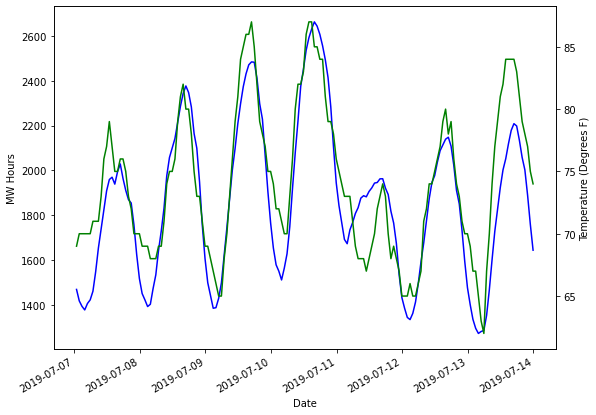

In [23]:
train_mw = train['MW']
train_t = train['Temp']

ax1 = train_mw['2019-07-07':'2019-07-13'].plot(color = 'blue', figsize=(9,7))

ax1.set_ylabel('MW Hours')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()

ax2 = train_t['2019-07-07':'2019-07-13'].plot(color = 'green', figsize=(9,7))

ax2.set_ylabel('Temperature (Degrees F)')

plt.show()

Wow! These lines are almost on top of each other! It seems that in the summer, energy usage follows very closely with temperature. As temperature goes up, so does energy usage. As temperature goes down, do does energy usage.

One measure of strength of a relationship between variables is correlation. We can easily calculate the correlation between temperature and energy using the ```corr``` funtion on our pandas data frame.

In [24]:
correlation = train['Temp'].corr(train['MW'])
print("Correlation is: ", correlation)

Correlation is:  0.3275395569074122


Maybe you were thinking that correlation number (bounded between -1 and 1 with 0 being no relationship) would be larger in magnitude. Remember, correlation is a measure of *linear* relationship. Although temperature and energy move together in summer, they move opposite in winter. In you were to only look at correlation in only those seasons then it would be much stronger. But they have opposite effects which makes that correlation number look a little weaker.

From the previous plots we definitely know something is happening between temperature and energy usage. Let's actually create a scatter plot between temperature (the x-axis) and energy usage (y-axis).

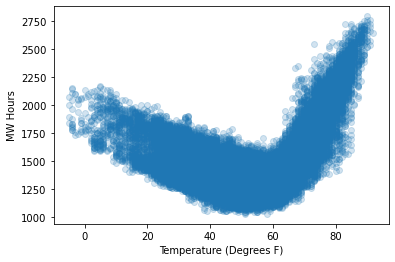

In [25]:
plt.scatter(train['Temp'], train['MW'], alpha = 0.2)
plt.xlabel('Temperature (Degrees F)')
plt.ylabel('MW Hours')
plt.show()

Perfect! Energy and temperature definitely have a relationship, just a little bit of a complicated one. You could probably say that it is quadratic in nature. The interesting part is where the relationship seems to change. Looks like below 60 degrees Fahrenheit as temperature goes down, energy goes up. However, above 60 degrees Fahrenheit, as temperature goes up, so does energy usage.

Understanding the complicated relationship between these two variables through visualizations helps inform the first energy model and forecast we will build in the next section. Without this understanding our models will not be as accurate as they could be. Remember that accuracy is key in this industry. You need to deliver an accurate model to your boss. You don't want a model that works in only some seasons of the year!